In [82]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
import glob
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


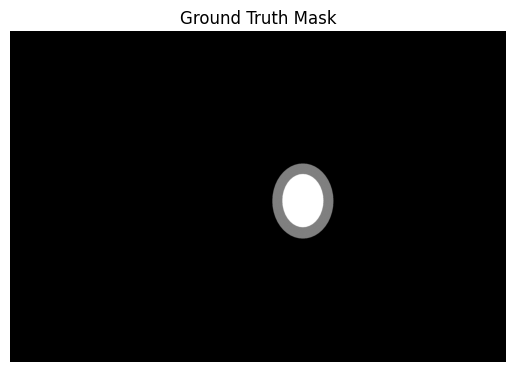

In [83]:
import scipy.io
import matplotlib.pyplot as plt

# Load the .mat file
mat = scipy.io.loadmat(r'ORIGA/ORIGA/Semi-automatic-annotations/001.mat')

# Extract the mask
mask = mat['mask']  # This is a numpy array of shape (2048, 3072)

# Visualize the mask
plt.imshow(mask, cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')
plt.show()

In [84]:
class ROISegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, mask_key='mask'):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.mask_key = mask_key

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        image = Image.open(image_path).convert('RGB')
        mat = scipy.io.loadmat(mask_path)
        mask = mat[self.mask_key]  # (H, W)

        if mask.shape != image.size[::-1]:
            mask = Image.fromarray(mask.astype(np.uint8))
            mask = mask.resize(image.size, resample=Image.NEAREST)
            mask = np.array(mask)

        if mask.ndim == 2:
            mask = mask[np.newaxis, ...]  # (1, H, W)

        image = np.array(image).transpose(2, 0, 1) / 255.0  # (C, H, W)
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        if self.transform:
            # You can apply transforms here, e.g., using torchvision.transforms.functional
            pass

        return image, mask

Number of images: 650
Number of masks: 650


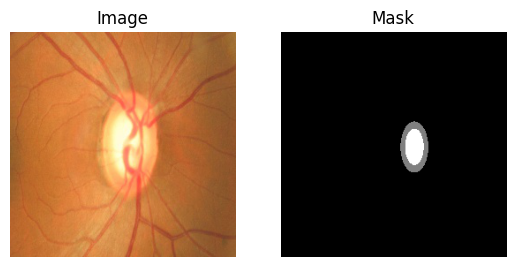

In [85]:
import os
from glob import glob
if __name__ == "__main__":
    image_dir = 'ORIGA/ORIGA/roi_images'
    mask_dir = 'ORIGA/ORIGA/Semi-automatic-annotations'

    # Get sorted lists of image and mask file paths
    image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))  # adjust extension if needed
    mask_paths = sorted(glob(os.path.join(mask_dir, "*.mat")))

    print("Number of images:", len(image_paths))
    print("Number of masks:", len(mask_paths))
    assert len(image_paths) == len(mask_paths), "Mismatch between images and masks!"

    dataset = ROISegmentationDataset(image_paths, mask_paths)

    # Visualize one sample
    import matplotlib.pyplot as plt
    img, msk = dataset[0]
    plt.subplot(1,2,1)
    plt.imshow(img.permute(1,2,0))
    plt.title('Image')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(msk.squeeze(), cmap='gray')
    plt.title('Mask')
    plt.axis('off')
    plt.show()

In [87]:


# Get basenames (without extension)
image_basenames = {os.path.splitext(os.path.basename(f))[0]: f for f in image_paths}
mask_basenames = {os.path.splitext(os.path.basename(f))[0]: f for f in mask_paths}

# Only keep pairs that exist in both
common_names = sorted(set(image_basenames) & set(mask_basenames))
paired_images = [image_basenames[name] for name in common_names]
paired_masks = [mask_basenames[name] for name in common_names]


In [88]:
train_imgs, test_imgs, train_masks, test_masks = train_test_split(
    paired_images, paired_masks, test_size=0.2, random_state=42)

print("Train images:", len(train_imgs))
print("Test images:", len(test_imgs))

Train images: 520
Test images: 130


In [89]:
train_dataset = ROISegmentationDataset(train_imgs, train_masks)
test_dataset = ROISegmentationDataset(test_imgs, test_masks)

In [90]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [91]:
# Example: device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Example loss and optimizer (customize as needed)
criterion = torch.nn.BCEWithLogitsLoss()  # for binary segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [92]:


# ---- Simple U-Net Model ----
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2, 2)
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2, 2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU())

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.conv_last = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        b = self.bottleneck(p2)
        up2 = self.up2(b)
        cat2 = torch.cat([up2, e2], dim=1)
        d2 = self.dec2(cat2)
        up1 = self.up1(d2)
        cat1 = torch.cat([up1, e1], dim=1)
        d1 = self.dec1(cat1)
        out = self.conv_last(d1)
        return out


def train_unet(model, train_loader, criterion, optimizer, device, epochs=5):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)
        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")



In [ ]:
model = UNet(in_channels=3, out_channels=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Make sure you call your training function!
train_unet(model, train_loader, criterion, optimizer, device, epochs=5)

AttributeError: 'ROISegmentationDataset' object has no attribute 'paired'

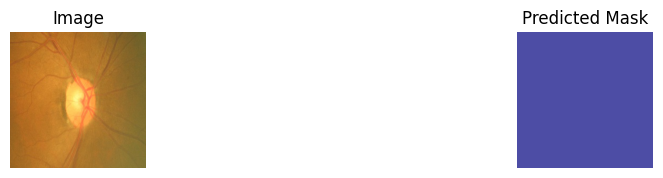

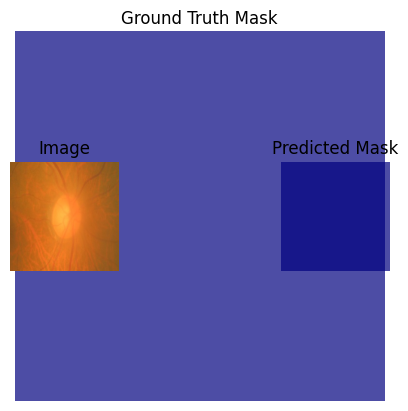

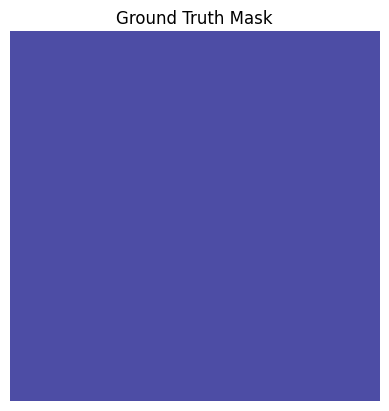

In [ ]:
model.eval()
with torch.no_grad():
    for images, masks in train_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        images = images.cpu().numpy()
        masks = masks.cpu().numpy()
        plt.figure(figsize=(12,6))
        for i in range(min(2, images.shape[0])):
            plt.subplot(3,2,i*2+1)
            plt.imshow(np.transpose(images[i], (1,2,0)))
            plt.title('Image')
            plt.axis('off')
            plt.subplot(3,2,i*2+2)
            plt.imshow(preds[i], cmap='jet', alpha=0.7)
            plt.title('Predicted Mask')
            plt.axis('off')
            plt.figure()
            plt.imshow(masks[i], cmap='jet', alpha=0.7)
            plt.title('Ground Truth Mask')
            plt.axis('off')
        break

In [ ]:
print(torch.unique(masks))

TypeError: _unique2(): argument 'input' (position 1) must be Tensor, not numpy.ndarray